TODO:
 1. Add more exploratory data analysis (and its own section)
 2. Figure out a better way to merge the columns
 3. Use cross validation in training
 4. Hyper parameter tuning for all of the classifiers

ideas
- bin education (highscool or below, bachelors, masters, doctorate, associate)
- is fnlwgt useful? -- read more on this one
- look into what '?' is for workclass, do we want to drop this attribute?
	- same issue for native country
- possibly bin martial status as well -- as this may not be useful to have so many classes
- see how useful capital loss/gains are -- this may indicate the person is active in the stock market and therefore may have more disposable income
- hours per week may also be a strong indicator of if they make over 50k a year
- what is relationship in the context of the dataset?
- can we further bin the occupation category as well?

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import wandb

In [23]:
def train_and_get_stats(clf, X_train, Y_train, X_test, Y_test):
    start = time.time()
    clf.fit(X_train, Y_train)
    end = time.time()
    training_time = end - start
    
    train_acc = clf.score(X_train, Y_train)
    test_acc = clf.score(X_test, Y_test)
    
    return {'train_time': training_time, 'train_acc': train_acc, 'test_acc': test_acc}

# Data preprocessing

In [4]:
data = pd.read_csv('data/adult.data')
test = pd.read_csv('data/adult.test')

In [5]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary-class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [6]:
test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary-class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [7]:
# get discrete class columns from data, and one hot encode
discrete_classes = ['workclass',
                    'education', 
                    'sex',
                    'marital-status',
                    'occupation',
                    'relationship', 
                    'native-country',
                    'race', 
                    'salary-class']
encoded_train = pd.get_dummies(data[discrete_classes])
encoded_test = pd.get_dummies(test[discrete_classes])

# drop old non-encoded columns from data, and add encoded data
data.drop(columns=discrete_classes, inplace=True)
data = pd.concat([data, encoded_train], axis=1)
test.drop(columns=discrete_classes, inplace=True)
test = pd.concat([test, encoded_test], axis=1)

# drop extra output column as 'salary <= 50k' -> 0, and 'salary >50k' -> 1
data.drop(columns=['salary-class_ <=50K'], inplace=True)
data.rename(columns={'salary-class_ >50K': 'salary-class'}, inplace=True)
test.drop(columns=['salary-class_ <=50K'], inplace=True)
test.rename(columns={'salary-class_ >50K': 'salary-class'}, inplace=True)

In [8]:
#TODO: figure out what to do in order to merge the columns better
x_keys = set(data.keys()) - set(['salary-class']) & set(test.keys()) - set(['salary-class'])
# x_test_keys = set(test.keys()) - set(['salary-class'])
y_keys = set(['salary-class'])

X_train = data[x_keys]
X_test = test[x_keys]

Y_train = data[y_keys]
Y_test = test[y_keys]

In [9]:
# X_train.shape[0]
np.rint(np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1.0]) * X_train.shape[0])

array([ 1628.,  3256.,  8140., 16280., 24421., 32561.])

In [55]:
# plt.figure(figsize=(10,10))
# eds = [col for col in data if col.startswith('education_')]
# race = [col for col in data if col.startswith('race_')]
# country = [col for col in data if col.startswith('native-country_')]
# occupation = [col for col in data if col.startswith('occupation_')]
# relation = [col for col in data if col.startswith('relationship_')]
# corrs = data[['salary-class'] + relation].corr()
# sns.heatmap(corrs)
# print(corrs)

In [56]:
# wandb.init(project='cs7641_p01', entity='bromero')

# Experiments

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from wandb.xgboost import wandb_callback
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

## Decision Tree classifier

In [24]:
dt_classifier = DecisionTreeClassifier(max_depth = 10, criterion='gini', splitter='best', random_state=42)
train_and_get_stats(dt_classifier, X_train, Y_train, X_test, Y_test)
# dt_classifier.fit(X_train, Y_train)
# dt_classifier.score(X_test, Y_test)
# wandb.sklearn.plot_learning_curve(dt_classifier, X_train, Y_train)

{'train_time': 0.30167508125305176,
 'train_acc': 0.8703971008261417,
 'test_acc': 0.8606350961243167}

In [153]:
# dt_classifier.score(X_test, Y_test)
# y_pred = dt_classifier.predict(X_test)
# y_probas = dt_classifier.predict_proba(X_test)
# [0]

# shows how the model behaves as you add more data
# train_sizes, train_scores, valid_scores = learning_curve(DecisionTreeClassifier(max_depth = 10, criterion='gini', splitter='best', random_state=42), X_train, Y_train, train_sizes=np.linspace(.1, 1.0, 5))

In [14]:
# wandb.sklearn.plot_classifier(dt_classifier, X_train, X_test, Y_train, Y_test, y_pred, y_probas, [0, 1], model_name='Decision Tree', feature_names=X_train.keys())

## Support Vector Machine classifier

In [128]:
svc = SVC(probability=True, C=0.5, degree=3, kernel='rbf')
svc.fit(X_train, Y_train['salary-class'])
svc.score(X_test, Y_test)
# wandb.sklearn.plot_learning_curve(svc, X_train,  Y_train['salary-class'])

0.790369141944598

In [16]:
svc.score(X_test, Y_test)
# y_pred = svc.predict(X_test)
# y_probas = svc.predict_proba(X_test)

0.7986610159081138

In [17]:
# wandb.sklearn.plot_classifier(svc, X_train, X_test, Y_train['salary-class'], Y_test['salary-class'], y_pred, y_probas, [0, 1], model_name='SVC', feature_names=X_train.keys())

## K Nearest Neighbors classifier

In [15]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn_classifier.fit(X_train, Y_train['salary-class'])
knn_classifier.score(X_test, Y_test)
# wandb.sklearn.plot_learning_curve(knn_classifier, X_train, Y_train['salary-class'])

0.7710828573183466

In [13]:
knn_classifier.score(X_test, Y_test)
# y_pred = knn_classifier.predict(X_test)
# y_probas = knn_classifier.predict_proba(X_test)

0.7991523862170629

In [20]:
# wandb.sklearn.plot_classifier(knn_classifier, X_train, X_test, Y_train['salary-class'], Y_test['salary-class'], y_pred, y_probas, [0, 1], model_name='KNN', feature_names=None)

## Neural Network classifier

In [90]:
nn_classifier = MLPClassifier(hidden_layer_sizes=(10), activation='relu', solver='adam', alpha=0.0001, random_state=1)
nn_classifier.fit(X_train, Y_train['salary-class'])
nn_classifier.score(X_test, Y_test)
# wandb.sklearn.plot_learning_curve(nn_classifier, X_train, Y_train['salary-class'])

0.8211412075425343

In [76]:
nn_classifier.score(X_test, Y_test)
# y_pred = nn_classifier.predict(X_test)
# y_probas = nn_classifier.predict_proba(X_test)

0.8211412075425343

In [87]:
np.linspace(1, 25, 25)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.])

In [83]:
# wandb.sklearn.plot_classifier(nn_classifier, X_train, X_test, Y_train['salary-class'], Y_test['salary-class'], y_pred, y_probas, [0, 1], model_name='Neural Network', feature_names=None)
# estimator = DecisionTreeClassifier(max_depth = 10, criterion='gini', splitter='best', random_state=42)
estimator = KNeighborsClassifier()
param_range = np.linspace(1, 25, 25)

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, Y_train, param_name="n_neighbors", param_range=[1, 2, 3, 4, 5], cv=5, n_jobs=4, scoring = "accuracy")
train_scores

# plt.figure(figsize=(10, 10))
# plt.xlabel("Max Depth")
# plt.ylabel("Score")
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)
# plt.legend(loc="best")
# plt.show()


KeyboardInterrupt: 

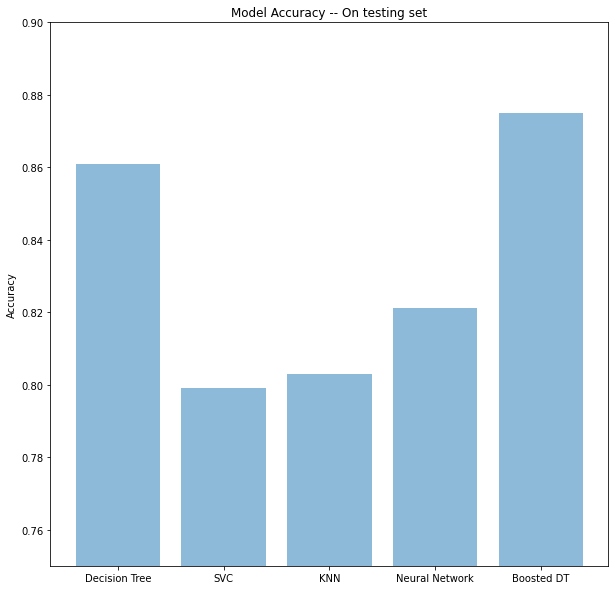

In [69]:
objects = ('Decision Tree', 'SVC', 'KNN', 'Neural Network', 'Boosted DT')
y_pos = np.arange(len(objects))
performance = [0.861,0.799,0.803,0.821,0.875]

plt.figure(figsize=(10, 10))
plt.ylim(0.75, 0.9)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Model Accuracy -- On testing set')

plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

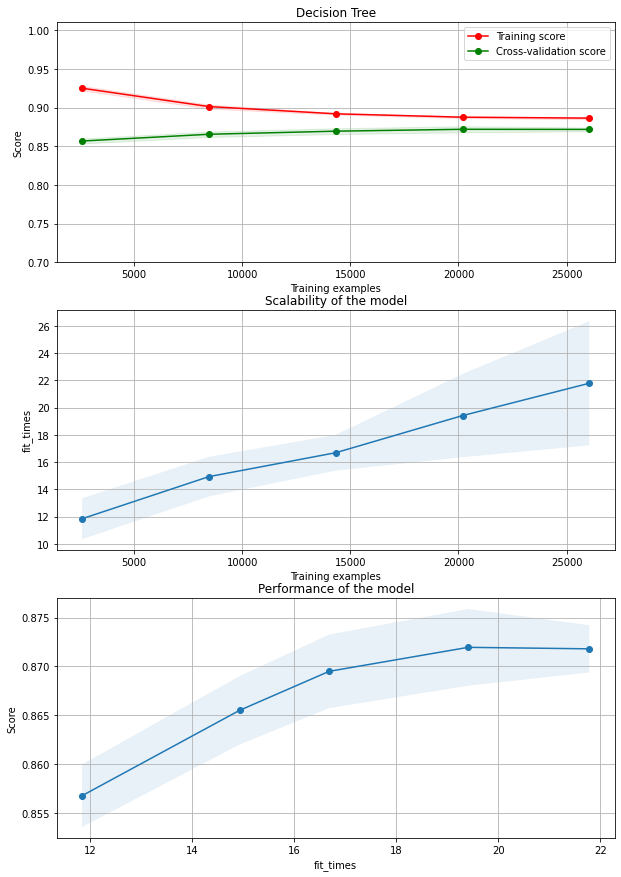

In [70]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# estimator = DecisionTreeClassifier(max_depth = 10, criterion='gini', splitter='best', random_state=42)
estimator = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=42)
plot_learning_curve(estimator, "Decision Tree", X_train, Y_train, axes=axes[:], ylim=(0.7, 1.01),
                    cv=None, n_jobs=8)

# estimator = MLPClassifier(hidden_layer_sizes=(10), activation='relu', solver='adam', alpha=0.0001, random_state=1)
# plot_learning_curve(estimator, "Neural Network", X_train, Y_train, axes=axes[:, 1],
#                     cv=cv, n_jobs=4)

# estimator = KNeighborsClassifier(n_neighbors=25)
# plot_learning_curve(estimator, "KNN Classifier", X_train, Y_train, axes=axes[:, 1],
#                     cv=cv, n_jobs=8)

## Boosted Decision Trees classifier

In [126]:
clf = xgb.XGBClassifier(n_estimators=50, max_depth=5, random_state=42)
clf.fit(X_train, Y_train['salary-class'])#, callbacks=[wandb_callback()])
clf.score(X_test, Y_test)

c:\users\jacob\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:27:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8751919415269332

In [63]:
# clf.score(X_test, Y_test)
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

# Dataset 2

In [149]:
data2 = pd.read_csv('data/UCI_Credit_Card.csv')
target_column = ['default.payment.next.month']
set(data2.columns)

{'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'EDUCATION',
 'ID',
 'LIMIT_BAL',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'SEX',
 'default.payment.next.month'}

In [150]:
print(data2.index[data2['EDUCATION'] == 0].shape)
print(data2.index[data2['MARRIAGE'] == 0].shape)
54+14

(14,)
(54,)


68

In [151]:
data2.loc[(data2.SEX == 1), 'SEX'] = 'male'
data2.loc[(data2.SEX == 2), 'SEX'] = 'female'

data2.drop(index=data2.index[data2['EDUCATION'] == 0], inplace=True)
data2.loc[(data2.EDUCATION == 1), 'EDUCATION'] = 'graduate school'
data2.loc[(data2.EDUCATION == 2), 'EDUCATION'] = 'university'
data2.loc[(data2.EDUCATION == 3), 'EDUCATION'] = 'high school'
data2.loc[(data2.EDUCATION == 4), 'EDUCATION'] = 'others'
data2.loc[(data2.EDUCATION == 5), 'EDUCATION'] = 'unknown'
data2.loc[(data2.EDUCATION == 6), 'EDUCATION'] = 'unknown'

data2.drop(index=data2.index[data2['MARRIAGE'] == 0], inplace=True)
data2.loc[(data2.MARRIAGE == 1), 'MARRIAGE'] = 'married'
data2.loc[(data2.MARRIAGE == 1), 'MARRIAGE'] = 'married'
data2.loc[(data2.MARRIAGE == 2), 'MARRIAGE'] = 'single'
data2.loc[(data2.MARRIAGE == 3), 'MARRIAGE'] = 'others'

data2.drop(columns=['ID'], inplace=True)

discerete_columns = [
    'SEX',
    'EDUCATION',
    'MARRIAGE'
]
encoded_train2 = pd.get_dummies(data2[discerete_columns])

# drop old non-encoded columns from data, and add encoded data
data2.drop(columns=discerete_columns, inplace=True)
data2 = pd.concat([data2, encoded_train2], axis=1)

# # Worse performance, when trying to use feature engineering
# for i in range(1, 7):
#     data2[f'PAY_RATIO{i}'] = (data2[f'PAY_AMT1']/data2[f'BILL_AMT1'])
# data2[data2.filter(regex="PAY_RATIO").columns] = data2.filter(regex="PAY_RATIO").fillna(0)
# data2.replace([np.inf, -np.inf], 0.0, inplace=True)
# data2.drop(columns=data2.filter(regex="([BILL|PAY]_AMT.*\d)").columns, inplace=True)

# Drop columns which are causing accuracy to drop
data2.drop(columns=data2.filter(regex="(SEX_)").columns, inplace=True)
data2.drop(columns=data2.filter(regex="(MARRIAGE_)").columns, inplace=True)
data2.drop(columns=data2.filter(regex="(LIMIT_BAL)").columns, inplace=True)
data2.drop(columns=['AGE'], inplace=True)

set(data2.columns)

{'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'EDUCATION_graduate school',
 'EDUCATION_high school',
 'EDUCATION_others',
 'EDUCATION_university',
 'EDUCATION_unknown',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default.payment.next.month'}

In [152]:
x_keys2 = set(data2.keys()) - set(target_column) & set(data2.keys()) - set(target_column)
y_keys2 = set(target_column)

first_split = data2.sample(frac=0.6,random_state=200)
second_split = data2.drop(first_split.index)

X_train2 = first_split[x_keys2]
Y_train2 = first_split[y_keys2]

X_test2 = second_split[x_keys2]
Y_test2 = second_split[y_keys2]

In [ ]:
# X_train2.describe()

In [ ]:
data2.filter(regex="([BILL|PAY]_AMT.*\d)").columns

In [ ]:
# data2

## Decision Tree classifier 2

In [153]:
dt_classifier2 = DecisionTreeClassifier(max_depth = 5, criterion='gini', splitter='best', random_state=42)
dt_classifier2.fit(X_train2, Y_train2)
# wandb.sklearn.plot_learning_curve(dt_classifier2, X_train, Y_train)

dt_classifier2.score(X_test2, Y_test2)
# y_pred = dt_classifier2.predict(X_test)
# y_probas = dt_classifier2.predict_proba(X_test)

TypeError: __init__() got an unexpected keyword argument 'weights'

## Support Vector Machine classifier

In [ ]:
svc2 = SVC(probability=True, C=1.0, degree=3, kernel='rbf')
svc2.fit(X_train2, Y_train2)
# wandb.sklearn.plot_learning_curve(svc2, X_train,  Y_train['salary-class'])

svc2.score(X_test2, Y_test2)
# y_pred = svc2.predict(X_test)
# y_probas = svc2.predict_proba(X_test)

## K Nearest Neighbors classifier

In [155]:
knn_classifier2 = KNeighborsClassifier(n_neighbors=20, weights='uniform')
knn_classifier2.fit(X_train2, Y_train2)
# wandb.sklearn.plot_learning_curve(knn_classifier2, X_train, Y_train['salary-class'])

knn_classifier2.score(X_test2, Y_test2)
# y_pred = knn_classifier2.predict(X_test)
# y_probas = knn_classifier2.predict_proba(X_test)

/usr/local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7757454272112253

## Neural Network classifier

In [ ]:
nn_classifier2 = MLPClassifier(hidden_layer_sizes=(100),  alpha=0.001, activation='relu', random_state=1337)
nn_classifier2.fit(X_train2, Y_train2)
# wandb.sklearn.plot_learning_curve(nn_classifier2, X_train, Y_train['salary-class'])

nn_classifier2.score(X_test2, Y_test2)
# y_pred = nn_classifier2.predict(X_test)
# y_probas = nn_classifier2.predict_proba(X_test)

## Boosted Decision Trees classifier

In [ ]:
# n_estimators=3, 
clf2 = xgb.XGBClassifier(n_estimators=3, max_depth=4, learning_rate=.1)
clf2.fit(X_train2, Y_train2)#, callbacks=[wandb_callback()])
clf2.score(X_test2, Y_test2)